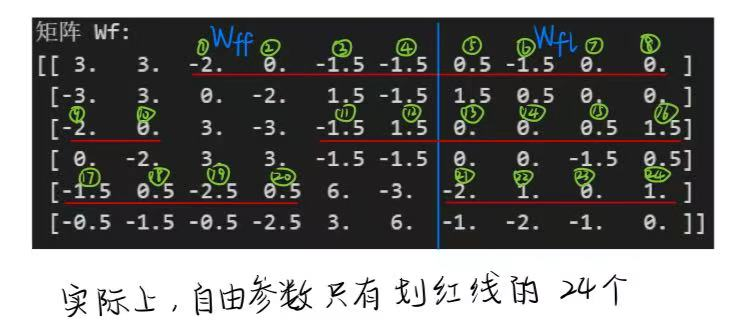
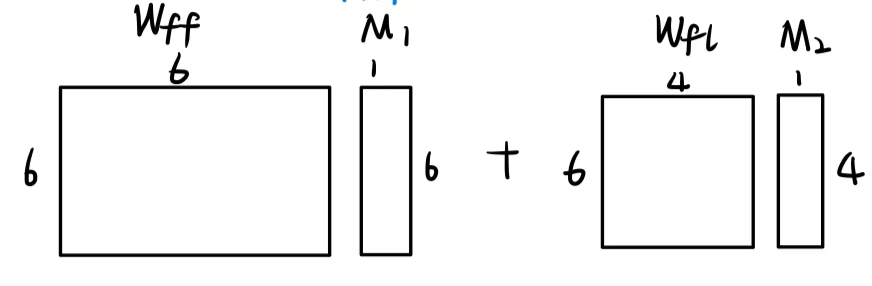

In [2]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint

def estimate_Wff_Wfl(pf, sl, kp, eps_T, max_iter=5000):
    """
    估计 W_ff (6x6) 和 W_fl (6x4)，显式约束行和为零
    
    参数:
        pf: 跟随者位置 (6, T) = [x1,y1, x2,y2, x3,y3]^T
        sl: 领导者状态 (8, T) = [lx1,ly1, lx2,ly2, lvx1,lvy1, lvx2,lvy2]^T
        kp: 已知控制增益
        eps_T: 时间步长
        max_iter: 最大迭代次数
    
    返回:
        W_ff: 形状 (6,6)
        W_fl: 形状 (6,4)
    """
    # ================== 数据预处理 ==================
    df, T = pf.shape[0], pf.shape[1]
    dl = sl.shape[0] // 2  # 领导者数量 × 2维
    
    assert df == 6, "pf 应为6维 (3跟随者×2维)"
    assert dl == 4, "sl 应为8行 (2领导者×4维)"
    
    # 构造 B
    B = np.zeros((dl, 2*dl)) # B = [-eps_T*kp*I, -eps_T*I]
    B[:, 0:dl] = -eps_T * kp * np.eye(dl)
    B[:, dl:] = -eps_T * np.eye(dl)

    # 构造 B @ sl
    B_sl = B @ sl
    
    # 计算状态变化 Δp_f(t) = p_f(t+1) - p_f(t) (形状 (6, T-1))
    delta_pf = pf[:, 1:] - pf[:, :-1]
    
    # Wff @ (delta_pf + eps_T * kp * pf) + Wfl @ B @ sl = GussianNoise
    #
    # -> Wff @ M1 + Wfl @ M2 = GussianNoise
    #
    # 其中 M1 = delta_pf + eps_T * kp * pf, M2 = B @ sl
    M1 = delta_pf + eps_T * kp * pf[:, :-1]     # 形状 (6, T-1)
    M2 = B_sl[:, :-1]                           # 形状 (4, T-1)

    M = - M1 @ M2.T @ np.linalg.inv(M2 @ M2.T)  # 形状 (6, 4)
    print(M)

    # ================== 参数化设置 ==================
    # 自由参数总数:
    # - W_ff: 6x6矩阵
    # - W_fl: 6x4矩阵
    # - 共 24 个参数
    total_params = 24
    
    # ================== 构建回归矩阵Phi和响应Y ==================
    Phi = np.zeros((6*(T-1), total_params))
    Y = np.zeros((6*(T-1), 1))  # 形状 (6*(T-1), 1)
    
    # 构建 Phi 和 Y
    for t in range(T-1):
        # row1
        Phi[6*t, 0] = -M1[0, t] + M1[2, t]  # param 1
        Phi[6*t, 1] = -M1[1, t] + M1[3, t]  # param 2
        Phi[6*t, 2] = -M1[0, t] + M1[4, t]  # param 3
        Phi[6*t, 3] = -M1[1, t] + M1[5, t]  # param 4
        Phi[6*t, 4] = -M1[0, t] + M2[0, t]  # param 5
        Phi[6*t, 5] = -M1[1, t] + M2[1, t]  # param 6
        Phi[6*t, 6] = -M1[0, t] + M2[2, t]  # param 7
        Phi[6*t, 7] = -M1[1, t] + M2[3, t]  # param 8
        Y[6*t] = np.random.normal(0, 0.01)  # 噪声项
        # row2
        Phi[6*t+1, 0] = -M1[1, t] + M1[3, t]  # param 1
        Phi[6*t+1, 1] = M1[0, t] - M1[2, t]   # param 2
        Phi[6*t+1, 2] = -M1[1, t] + M1[5, t]  # param 3
        Phi[6*t+1, 3] = M1[0, t] - M1[4, t]   # param 4
        Phi[6*t+1, 4] = -M1[1, t] + M2[1, t]  # param 5
        Phi[6*t+1, 5] = M1[0, t] - M2[0, t]   # param 6
        Phi[6*t+1, 6] = -M1[1, t] + M2[3, t]  # param 7
        Phi[6*t+1, 7] = M1[0, t] - M2[2, t]   # param 8
        Y[6*t+1] = np.random.normal(0, 0.01)  # 噪声项
        # row3
        Phi[6*t+2, 8] = -M1[2, t] + M1[0, t]  # param 9
        Phi[6*t+2, 9] = -M1[3, t] + M1[1, t]  # param 10
        Phi[6*t+2, 10] = -M1[2, t] + M1[4, t] # param 11
        Phi[6*t+2, 11] = -M1[3, t] + M1[5, t] # param 12
        Phi[6*t+2, 12] = -M1[2, t] + M2[0, t] # param 13
        Phi[6*t+2, 13] = -M1[3, t] + M2[1, t] # param 14
        Phi[6*t+2, 14] = -M1[2, t] + M2[2, t] # param 15
        Phi[6*t+2, 15] = -M1[3, t] + M2[3, t] # param 16
        Y[6*t+2] = np.random.normal(0, 0.01)
        # row4
        Phi[6*t+3, 8] = -M1[3, t] + M1[1, t]  # param 9
        Phi[6*t+3, 9] = M1[2, t] - M1[0, t]   # param 10
        Phi[6*t+3, 10] = -M1[3, t] + M1[5, t] # param 11
        Phi[6*t+3, 11] = M1[2, t] - M1[4, t]  # param 12
        Phi[6*t+3, 12] = -M1[3, t] + M2[1, t] # param 13
        Phi[6*t+3, 13] = M1[2, t] - M2[0, t]  # param 14
        Phi[6*t+3, 14] = -M1[3, t] + M2[3, t] # param 15
        Phi[6*t+3, 15] = M1[2, t] - M2[2, t]  # param 16
        Y[6*t+3] = np.random.normal(0, 0.01)
        # row5
        Phi[6*t+4, 16] = -M1[4, t] + M1[0, t]  # param 17
        Phi[6*t+4, 17] = -M1[5, t] + M1[1, t]  # param 18
        Phi[6*t+4, 18] = -M1[4, t] + M1[2, t]  # param 19
        Phi[6*t+4, 19] = -M1[5, t] + M1[3, t]  # param 20
        Phi[6*t+4, 20] = -M1[4, t] + M2[0, t]  # param 21
        Phi[6*t+4, 21] = -M1[5, t] + M2[1, t]  # param 22
        Phi[6*t+4, 22] = -M1[4, t] + M2[2, t]  # param 23
        Phi[6*t+4, 23] = -M1[5, t] + M2[3, t]  # param 24
        Y[6*t+4] = np.random.normal(0, 0.01)
        # row6
        Phi[6*t+5, 16] = -M1[5, t] + M1[1, t]  # param 17
        Phi[6*t+5, 17] = M1[4, t] - M1[0, t]   # param 18
        Phi[6*t+5, 18] = -M1[5, t] + M1[3, t]  # param 19
        Phi[6*t+5, 19] = M1[4, t] - M1[2, t]   # param 20
        Phi[6*t+5, 20] = -M1[5, t] + M2[1, t]  # param 21
        Phi[6*t+5, 21] = M1[4, t] - M2[0, t]   # param 22
        Phi[6*t+5, 22] = -M1[5, t] + M2[3, t]  # param 23
        Phi[6*t+5, 23] = M1[4, t] - M2[2, t]   # param 24
        Y[6*t+5] = np.random.normal(0, 0.01)


            
    
    # ================== 约束条件：行和为零 ==================
    # 约束矩阵 A: 每行对应一个约束，确保 W_ff 和 W_fl 的行和为零
    # A = np.zeros((6, total_params))
    
    # for i in range(6):
    #     # W_ff 部分: 第i行的非对角元素（共5个）
    #     for j in range(6):
    #         if j != i:
    #             param_idx = i*5 + (j if j < i else j-1)  # 参数索引
    #             A[i, param_idx] = 1
        
    #     # W_fl 部分: 第i行的所有元素（共4个）
    #     A[i, num_Wff_params + i*4 : num_Wff_params + (i+1)*4] = 1
    
    # constraints = LinearConstraint(A, lb=0, ub=0)
    
    # ================== 非负约束 ==================
    # bounds = [(0, None) for _ in range(total_params)]
    
    # ================== 求解优化 ==================
    # res = minimize(
    #     fun=lambda theta: np.linalg.norm(Phi @ theta - Y)**2,
    #     x0=0.1*np.ones(total_params),
    #     method='Nelder-Mead',
    #     # bounds=bounds,
    #     # constraints=constraints,
    #     # options={'maxiter': max_iter, 'verbose': 1}
    #     tol=1e-6
    # )
    
    # if not res.success:
    #     raise RuntimeError(f"优化失败: {res.message}")
    
    # theta_opt = res.x
    theta_opt = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ Y
    theta_opt = theta_opt.flatten()
    
    # ================== 重构矩阵 ==================
    # 重构 W_ff (6x6)
    W_ff = np.zeros((6, 6))
    # row1
    W_ff[0, 0] = -(theta_opt[0] + theta_opt[2] + theta_opt[4] + theta_opt[6])
    W_ff[0, 1] = -(theta_opt[1] + theta_opt[3] + theta_opt[5] + theta_opt[7])
    W_ff[0, 2:6] = theta_opt[0:4]
    # row2
    W_ff[1, 0] = (theta_opt[1] + theta_opt[3] + theta_opt[5] + theta_opt[7])
    W_ff[1, 1] = -(theta_opt[0] + theta_opt[2] + theta_opt[4] + theta_opt[6])
    W_ff[1, 2] = -theta_opt[1]
    W_ff[1, 3] = theta_opt[0]
    W_ff[1, 4] = -theta_opt[3]
    W_ff[1, 5] = theta_opt[2]  
    # row3
    W_ff[2, 0:2] = theta_opt[8:10]
    W_ff[2, 2] = -(theta_opt[8] + theta_opt[10] + theta_opt[12] + theta_opt[14])
    W_ff[2, 3] = -(theta_opt[9] + theta_opt[11] + theta_opt[13] + theta_opt[15])
    W_ff[2, 4:6] = theta_opt[10:12]
    # row4
    W_ff[3, 0] = -theta_opt[9]
    W_ff[3, 1] = theta_opt[8]
    W_ff[3, 2] = (theta_opt[9] + theta_opt[11] + theta_opt[13] + theta_opt[15])
    W_ff[3, 3] = -(theta_opt[8] + theta_opt[10] + theta_opt[12] + theta_opt[14])
    W_ff[3, 4] = -theta_opt[11]
    W_ff[3, 5] = theta_opt[10]
    # row5
    W_ff[4, 0:4] = theta_opt[16:20]
    W_ff[4, 4] = -(theta_opt[16] + theta_opt[18] + theta_opt[20] + theta_opt[22])
    W_ff[4, 5] = -(theta_opt[17] + theta_opt[19] + theta_opt[21] + theta_opt[23])
    # row6
    W_ff[5, 0] = -theta_opt[17]
    W_ff[5, 1] = theta_opt[16]
    W_ff[5, 2] = -theta_opt[19]
    W_ff[5, 3] = theta_opt[18]
    W_ff[5, 4] = (theta_opt[17] + theta_opt[19] + theta_opt[21] + theta_opt[23])
    W_ff[5, 5] = -(theta_opt[16] + theta_opt[18] + theta_opt[20] + theta_opt[22])

    # 重构 W_fl (6x4)
    W_fl = np.zeros((6, 4))
    W_fl[0, :] = theta_opt[4:8]
    W_fl[1, 0] = -theta_opt[5]
    W_fl[1, 1] = theta_opt[4]
    W_fl[1, 2] = -theta_opt[7]
    W_fl[1, 3] = theta_opt[6]
    W_fl[2, :] = theta_opt[12:16]
    W_fl[3, 0] = -theta_opt[13]
    W_fl[3, 1] = theta_opt[12]
    W_fl[3, 2] = -theta_opt[15]
    W_fl[3, 3] = theta_opt[14]
    W_fl[4, :] = theta_opt[20:24]
    W_fl[5, 0] = -theta_opt[21]
    W_fl[5, 1] = theta_opt[20]
    W_fl[5, 2] = -theta_opt[23]
    W_fl[5, 3] = theta_opt[22]

    return W_ff, W_fl

# =============================================
# main
# =============================================
if __name__ == "__main__":
    # 假设用户提供的数据格式如下:
    # pf: (df, T) = (3, 2045)
    # sl: (2*dl, T) = (2, 2045) (dl=1 个领导者)
    eps_T = 0.5
    kp = 1  # 已知控制增益
    sl = np.load("Data_sl.npy")  # 领导者状态矩阵
    pf = np.load("Data_pf.npy")  # 跟随者位置矩阵
    
    # 估计参数
    W_ff_est, W_fl_est = estimate_Wff_Wfl(pf, sl, kp, eps_T, max_iter=100)
    
    print("Estimated W_ff:")
    print(W_ff_est)
    print("\nEstimated W_fl:")
    print(W_fl_est)

[[-0.21397354  0.01493245 -0.4581242   0.29879337]
 [ 0.64763571 -0.3373205   0.9396896  -1.19160234]
 [-1.04331196  0.53572156 -1.52433405  1.91214333]
 [ 1.05345413 -0.21461813  2.04560966 -1.61140276]
 [-0.5487536   0.45283888 -0.54268552  1.17394491]
 [ 0.18391666 -0.01603579  0.39104617 -0.2608326 ]]
Estimated W_ff:
[[-2.00150286e-06 -3.31861239e-05 -1.59984061e-05  1.90326438e-06
   1.61683517e-05  5.90037874e-06]
 [ 3.31861239e-05 -2.00150286e-06 -1.90326438e-06 -1.59984061e-05
  -5.90037874e-06  1.61683517e-05]
 [ 1.10782482e-04 -5.77688525e-05 -8.45020656e-05 -4.55267013e-05
   5.21794471e-05  1.08419342e-04]
 [ 5.77688525e-05  1.10782482e-04  4.55267013e-05 -8.45020656e-05
  -1.08419342e-04  5.21794471e-05]
 [ 2.48768204e-05 -5.57479190e-05 -3.23374152e-05  3.69918150e-05
   4.89457733e-05 -3.91248525e-05]
 [ 5.57479190e-05  2.48768204e-05 -3.69918150e-05 -3.23374152e-05
   3.91248525e-05  4.89457733e-05]]

Estimated W_fl:
[[ 4.73723052e-06 -3.57001379e-05 -2.90567328e-06  6.

In [15]:
pF = np.array([[ 5.00000000e-01],
 [ 5.00000000e-01],
 [ 5.00000000e-01],
 [-5.00000000e-01],
 [-1.11022302e-16],
 [ 5.55111512e-17]])
pL = np.array([[-1.],
 [ 1.],
 [-1.],
 [-1.]])

In [17]:
W_ff_est @ pF + W_fl_est @ pL

array([[2.47483370e-06],
       [1.27076920e-06],
       [2.28225419e-06],
       [1.81093172e-06],
       [2.39339494e-06],
       [1.13966383e-06]])

In [10]:
W_fl_est

array([[-5.78375310e-09, -6.00478264e-09,  5.38234110e-08,
        -6.00475016e-09],
       [-4.73027792e-09,  4.23435985e-08, -4.73027842e-09,
        -4.50074422e-09],
       [-4.68353355e-09, -4.72934459e-09,  4.25178895e-08,
        -4.72932256e-09],
       [-5.05485869e-09,  4.54568268e-08, -5.05488190e-09,
        -5.01745294e-09],
       [-4.66815291e-09, -4.73061662e-09,  4.25127692e-08,
        -4.73061208e-09],
       [-5.07896672e-09,  4.50973952e-08, -5.07913175e-09,
        -4.46520156e-09]])